<a href="https://colab.research.google.com/github/Hasan-Iqtedar/personality-classification/blob/main/ai_project_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [5]:
batch_size = 128
training_examples = 140
validation_examples = 24
data_dir = '/content/drive/MyDrive/ai_project/data'

In [6]:
from torchvision.transforms.transforms import Resize
dataset = ImageFolder(data_dir+'/train',
                      transform=transforms.Compose([transforms.Resize((200,200)), transforms.ToTensor()]) )

In [7]:
dataset

Dataset ImageFolder
    Number of datapoints: 164
    Root location: /content/drive/MyDrive/ai_project/data/train
    StandardTransform
Transform: Compose(
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [8]:
dataset.classes

['extrovert', 'introvert']

In [9]:
def imshow(img_tensor, label):
  plt.imshow(img_tensor.permute(1, 2, 0))
  plt.title(dataset.classes[label])

def show_grid(batch):
    images, labels = batch
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))

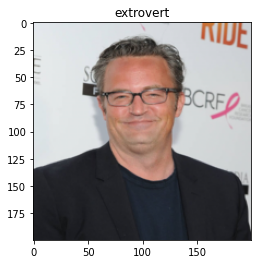

In [10]:
image, label = dataset[0]
imshow(image, label)

In [11]:
# To get the same validation set every time.
random_seed = 20
torch.manual_seed(random_seed);

train_ds, validation_ds = random_split(dataset, [training_examples, validation_examples])
len(train_ds), len(validation_ds)

(140, 24)

In [12]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_ds, batch_size=batch_size*2)

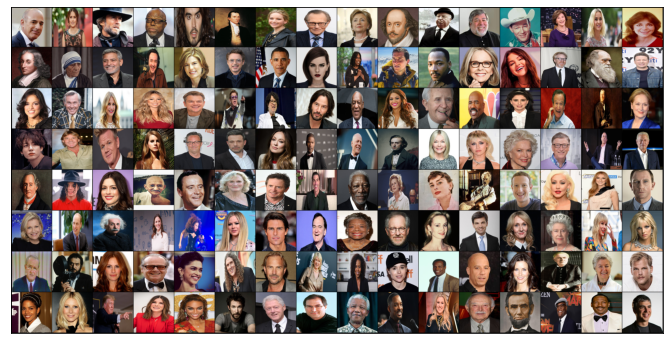

In [ ]:
for batch in train_loader:
  show_grid(batch)
  break

In [13]:
def compute_accuracy(predictions, labels):
  # dim=1 indicates max along each row.
  _, indices = torch.max(predictions, dim=1)
  return torch.tensor(torch.sum(indices == labels).item() / len(indices))

In [14]:
class ImageClassificationBase(nn.Module):
  def train_step(self, batch):
    images, labels = batch
    outputs = self(images)
    loss = F.cross_entropy(outputs, labels)
    return loss
  
  def validation_step(self, batch):
    images, labels = batch
    outputs = self(images)
    loss = F.cross_entropy(outputs, labels)
    accuracy = compute_accuracy(outputs, labels)
    return {'validation_batch_loss': loss, 'validation_batch_accuracy': accuracy}
  
  def validation_epoch_end(self, outputs):
    # Outputs: a list of dictionaries from above function.
    batch_losses = [x['validation_batch_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()

    batch_accuracies = [x['validation_batch_accuracies'] for x in outputs]
    epoch_accuracy = torch.stack(batch_accuracies).mean()

    return {'epoch_validation_loss': epoch_loss.item(), 'epoch_accuracy': epoch_accuracy.item()}
  
  def epoch_end(self, epoch,result):
    # result contains epoch losses (train and validation) and accuracy.
    print('Epoch[{}]: train loss: {:.4f}, validation loss: {:.4f}, accuracy: {:.4f}'
    .format(epoch, result['epoch_train_loss'], result['epoch_validation_loss'], result['epoch_accuracy']))

In [23]:
len(dataset.classes)

2

In [24]:
# from torch.nn.modules.flatten import Flatten
# from torch.nn.modules.pooling import MaxPool2d
# from torch.nn.modules.activation import ReLU
class Model(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        # 3 x 200 x 200
        nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # 24 x 200 x 200
        nn.Flatten(),
        nn.Linear(24*200*200, 1024),
        nn.ReLU(),
        nn.Linear(1024, 256),
        nn.ReLU(),
        # 3
        nn.Linear(256, 2))

  def forward(self, xb):
    return self.network(xb)  

In [27]:
model = Model()
model

Model(
  (network): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=960000, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [ ]:
@torch.no_grad()
def evaluate(model, validation_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in validation_loader]
  return model.validation_epoch_end(outputs)